In [1]:
from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.preprocessing import LabelBinarizer
from tpot import TPOT

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import custom_funcs as cf

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import seaborn as sns

sns.set_context('poster')

In this notebook, I will write the code that is necessary for training on the training set, and testing on the test set.

In [3]:
# Read in the protease inhibitor data
data = pd.read_csv('../data/hiv_data/hiv-protease-data.csv', index_col='SeqID')
drug_cols = data.columns[0:8]
feat_cols = data.columns[8:]

# Read in the consensus data
consensus = SeqIO.read('../data/hiv_data/hiv-protease-consensus.fasta', 'fasta')

consensus_map = {i:letter for i, letter in enumerate(str(consensus.seq))}

# Because there are '-' characters in the dataset, representing consensus sequence at each of the positions, 
# they need to be replaced with the actual consensus letter.

for i, col in enumerate(feat_cols):
    # Replace '-' with the consensus letter.
    data[col] = data[col].replace({'-':consensus_map[i]})
    
    # Replace '.' with np.nan
    data[col] = data[col].replace({'.':np.nan})
    
    # Replace 'X' with np.nan
    data[col] = data[col].replace({'X':np.nan})
    
# Drop any feat_cols that have np.nan inside them. We don't want low quality sequences.
data.dropna(inplace=True, subset=feat_cols)
data

,FPV,ATV,IDV,LPV,NFV,SQV,TPV,DRV,P1,P2,...,P90,P91,P92,P93,P94,P95,P96,P97,P98,P99
SeqID,,,,,,,,,,,,,,,,,,,,,
2996,2.5,NaN,16.3,NaN,38.6,16.1,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
4387,0.7,NaN,0.8,NaN,0.8,1.1,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4432,1.5,NaN,1.0,NaN,2.2,1.1,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4482,3.9,NaN,20.2,NaN,21.6,9.2,NaN,NaN,P,Q,...,M,T,Q,L,G,C,T,L,N,F
4486,9.5,20.0,8.2,11.0,72.0,46.0,NaN,NaN,P,Q,...,L,T,Q,I,G,C,T,L,N,F
4538,NaN,NaN,21.0,7.5,55.0,85.0,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
4664,3.1,NaN,8.7,NaN,32.0,16.9,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
4690,4.9,15.0,18.0,5.9,24.0,73.0,NaN,NaN,P,Q,...,M,T,Q,I,G,C,T,L,N,F
4698,1.2,NaN,0.7,NaN,3.6,1.3,NaN,NaN,P,Q,...,L,T,Q,L,G,C,T,L,N,F


In [4]:
# Grab out the drug name to be tested.
DRUG = drug_cols[0]

# I have written a custom function that takes in the data, and reduces it such that we only consider one drug column
# value, and the corresponding amino acid sequences. The NaN values are also dropped, as most machine learning
# algorithms in scikit-learn cannot deal with NaN values. Finally, the data are log10 transformed.
X, Y = cf.split_data_xy(data, feat_cols, DRUG)

# Binarize the sequence features such that there are 99 x 20 columns in total.
# The purpose of binarizing is to turn the string labels into numeric labels. The most naive way to do this is to 
# take every amino acid position in the sequence alignment, and turn it into 20 columns of 1s and 0s corresponding 
# to whether a particular amino acid is present or not.

lb = LabelBinarizer()
lb.fit(list('CHIMSVAGLPTRFYWDNEQK'))

X_binarized = pd.DataFrame()

for col in X.columns:
    binarized_cols = lb.transform(X[col])
    
    for i, c in enumerate(lb.classes_):
        X_binarized[col + '_' + c] = binarized_cols[:,i]
X_binarized

,P1_A,P1_C,P1_D,P1_E,P1_F,P1_G,P1_H,P1_I,P1_K,P1_L,...,P99_M,P99_N,P99_P,P99_Q,P99_R,P99_S,P99_T,P99_V,P99_W,P99_Y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Build the categorical values of resistance.
# value < 4-fold = sensitive
# 4-fold < value < 11-fold = intermediate
# value > 11-fold = resistant
#
# These values came from https://www.poz.com/basics/hiv-basics/hiv-drug-resistance,
# more particularly by observing the screen shot on the page.
# 
# Final note: we log10 transform the cutoffs, because all of the resistance
# values are also log10-transformed right now.

lower_bound = np.log10(4)
upper_bound = np.log10(11)

from sklearn.preprocessing import LabelEncoder

def categorize(x):
    if x < lower_bound:
        return 'sensitive'
    if x >= lower_bound and x <= upper_bound:
        return 'partially sensitive'
    else:
        return 'resistant'

Y_cat = pd.DataFrame()
Y_cat['resistance_class'] = Y.apply(lambda x: categorize(x))


le = LabelEncoder()
Y_cat = le.fit_transform(Y_cat['resistance_class'])

In [6]:
# Next step is to split the data into a training set and a test set. 
# We use the train_test_split function provided by the scikit-learn package to do this.
tts_cat = X_train_cat, X_test_cat, Y_train_cat, Y_test_cat = train_test_split(X_binarized, Y_cat, test_size=0.33)
tts_reg = X_train, X_test, Y_train, Y_test = train_test_split(X_binarized, Y, test_size=0.33)

In [7]:
Y_train

SeqID
81901     0.716003
74976     1.041393
205622    0.380211
61155    -0.154902
81897     0.579784
10294     0.301030
207303   -0.522879
89052     0.826075
61101     0.000000
147979   -0.096910
59254     0.447158
102769   -0.397940
58894     1.146128
147981    0.000000
145681   -0.045757
117073   -0.397940
68349    -0.397940
235721    0.672098
27476     0.113943
12932     0.342423
115894    0.322219
89952     1.755875
54396     0.892095
60805     0.732394
81793     0.041393
56172    -0.397940
75072    -0.301030
44090    -0.221849
145697   -0.154902
66266     1.041393
            ...   
148127   -0.096910
116515   -0.221849
40448     0.875061
54180     0.361728
7412      0.792392
13256    -1.000000
89964     0.322219
89038     0.748188
29047     0.176091
117023    1.462398
66672     1.568202
41692     1.173186
147975    1.146128
81859    -0.397940
61143     0.963788
257937    1.146128
216621   -0.221849
216657   -0.301030
40526     0.602060
259223   -0.096910
56110     1.748188
52840 

In [8]:
# # We will use TPOT to automatically find a best model

# tpot_model = TPOT(generations=10, verbosity=2)
# tpot_model.fit(X_train_cat, Y_train_cat)

In [9]:
# tpot_model.export('../scripts/fpv_classifer.py')

In [10]:
# !ls ../scripts

In [11]:
####

In [13]:
# # Try RandomForest Classifier
# from sklearn.ensemble import RandomForestClassifier

# rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
# rfc.fit(X_train_cat, Y_train_cat)
# preds = rfc.predict(X_test_cat)

# from sklearn.metrics import normalized_mutual_info_score as nmi
# from sklearn.metrics import accuracy_score
# accuracy_score(preds, Y_test_cat)

We will skip past a discussion of other regresison models, and instead focus here on the use of ensemble regressors.

I would encourage you to take a look at the documentation for each of the following regressors:

- Random Forest
- Gradient Boosting
- AdaBoost
- ExtraTrees
- Bagging

The purpose is to look for parameters that you can tweak to make the model better.

I have written a custom function called `train_model` that takes in

- the train/test splitted data, 
- a model, and 
- model arguments, 

and returns (in order):

- the trained model, 
- the model predictions, 
- the mean-squared error of the predictions, 
- and the correlation score (r-squared).

In [28]:
# Train a bunch of ensemble regressors:

## Random Forest
rfr_kwargs = {'n_jobs':-1, 'n_estimators':1000, 'n_jobs':-1}
rfr, rfr_preds, rfr_mse, rfr_r2 = cf.train_model(*tts_reg, model=RandomForestRegressor, modelargs=rfr_kwargs)

## Gradient Boosting
gbr_kwargs = {'n_estimators':1000, 'n_jobs':-1}
gbr, gbr_preds, gbr_mse, gbr_r2 = cf.train_model(*tts_reg, model=GradientBoostingRegressor, modelargs=gbr_kwargs)

## AdaBoost
abr_kwargs = {'n_estimators':1000}
abr, abr_preds, abr_mse, abr_r2 = cf.train_model(*tts_reg, model=AdaBoostRegressor, modelargs=abr_kwargs)

## ExtraTrees
etr_kwargs = {'n_estimators':1000, 'n_jobs':-1}
etr, etr_preds, etr_mse, etr_r2 = cf.train_model(*tts_reg, model=ExtraTreesRegressor, modelargs=etr_kwargs)

## Bagging
bgr, bgr_preds, bgr_mse, bgr_r2 = cf.train_model(*tts_reg, model=BaggingRegressor)

In [29]:
from xgboost import XGBRegressor

xbr_kwargs = {'max_depth': 10, 'subsample':0.5}
xbr, xbr_preds, xbr_mse, xbr_r2 = cf.train_model(*tts_reg, model=XGBRegressor, modelargs=xbr_kwargs)

In [30]:
xbr_mse

0.10264136723314964

In [31]:
# Compare the trained models. Which one minimizes the mean squared error the most?

rfr_mse, gbr_mse, abr_mse, etr_mse, bgr_mse

(0.1078452496974331,
 0.099303687945728233,
 0.14420845093137985,
 0.17930864707045815,
 0.11769356943666608)

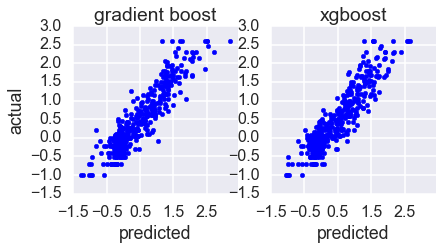

In [33]:
fig = plt.figure(figsize=(6.5, 3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(gbr_preds, Y_test, color='blue')
ax.set_ylabel('actual')
ax.set_xlabel('predicted')
ax.set_title('gradient boost')
ax.set_xticks(np.arange(-1.5, 3.5, 1))

ax2 = fig.add_subplot(1, 2, 2, sharey=ax, sharex=ax)
ax2.scatter(xbr_preds, Y_test, color='blue')
ax2.set_xlabel('predicted')
ax2.set_title('xgboost')

plt.savefig('figures/rf_gboost_baseline.pdf', bbox_inches='tight')

In [9]:
# Qualitatively, what is the math behind the MSE score? Are you looking to minimize or maximize it?

In [10]:
models = dict()
models['rfr'] = RandomForestRegressor(n_estimators=100, n_jobs=-1)
models['gbr'] = GradientBoostingRegressor(n_estimators=100)
models['abr'] = AdaBoostRegressor(n_estimators=100)
models['etr'] = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
models['bgr'] = BaggingRegressor()
models['xbr'] = XGBRegressor()

scores = cross_val_score(models['gbr'], X_binarized, Y, cv=ShuffleSplit(n=len(Y)))
scores

array([ 0.8661261 ,  0.8447757 ,  0.85979443,  0.85674131,  0.88628088,
        0.90356043,  0.87255452,  0.85725349,  0.86931921,  0.81822711])